# 0. Setup

In [1]:
# libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.regularizers import L2

# working directories
WORKDIR = os.path.abspath('D:\\Users\\nbakotic\\iccecme-dataset') # get the path of this file - image metadata
IMAGESDIR = os.path.join(WORKDIR, 'images') # get the path of image folder

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 1.1 - Load and Process Metadata

0. Load data.
1. Drop columns other than WindowCenter and WindowWidth. In this experiment, the goal is to see how well the model can predict these values from images alone. Another model will be built later to see impact of remaining features on predictions.
2. Some values for WindowCenter and WindowWidth contain more than one number. In those cases, the first value will be used for learning, like in "Using Autoencoders to Reduce Dimensionality of DICOM Metadata".
3. Convert string values to float32.

In [3]:
# 0. read metadata
metadata_df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')

# 1. drop columns that will not be used for the task
metadata_df = metadata_df.drop(columns=['Modality', 'Rows', 'Columns', 'BodyPartExamined', 'HighBit', 'StudyDescription'])

# 2. format numbers
# find cells that contain two instead of one number and return only the first number
def extract_number_from_list(val):
    if ',' in val:
        idx = val.find(',')
        return val[1:idx]
    else:
        return val
    
metadata_df = metadata_df.applymap(extract_number_from_list)

# 3. convert string values to float
metadata_df['WindowCenter'] = metadata_df['WindowCenter'].astype('float32')
metadata_df['WindowWidth'] = metadata_df['WindowWidth'].astype('float32')

# 1.2 Load and Process Images
0. Read images from folder. Because of .npy format, they are ready into a list and converted to ndarray.
1. Add padding to images so they are all the same size. Most images are around 512 x 512 px so those dimensions are used.
2. Some images contain values below 0, but as they show as black, they are converted to 0.
3. Grayscale images have one color channel, but this dimension is dropped by default in the array so it has to be added back.
4. Normalize the data. Since images range from 8-bit to 16-bit, the values are divided by 2^16 - 1.

In [69]:
# 0. loading images
# read an image with file_name from images directory
# images are already in numpy format
def read_file(file_name):
    imagepath = os.path.join(IMAGESDIR, f'{file_name}.npy')
    with open(imagepath, 'rb') as file:
        img = np.load(file)
    return img

# temporary image list to load files into
images_list = []
for i in range(len(metadata_df)):
    img = read_file(metadata_df.index[i])
    images_list.append(img)

#since images are loaded into a list, they will be converted into a numpy array
images = np.array(images_list, dtype=np.ndarray)

#free up the memory of images_list
del images_list


# 1. add padding to the images so they are all the same size
for i in range(len(images)):
    images[i] = pad_sequences(images[i], value=0,padding='post', maxlen=512)
    
images = pad_sequences(images, value=0,padding='post', maxlen=512)

# 2. negative values show as black, so they are converted to 0
images[images < 0] = 0

# 3. add color dimension into the array
images = np.expand_dims(images, -1)

# 4. normalize the data - images range from 8 bit to 16 bit
images = images / 65535

# 2. Create Datasets
Because the dataset is large, it is not possible to put all of it at once in the GPU memory. Creating a dataset using 'tf.data.Dataset.from_tensor_slices' is also not possible, therefore a custom DataGenerator class is used.

1. Create train-validation-test datasets.

In [5]:
# custom dataset generator class
from tensorflow.keras.utils import Sequence 
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = (self.y[0][idx * self.batch_size:(idx + 1) * self.batch_size], self.y[0][idx * self.batch_size:(idx + 1) * self.batch_size])
        return batch_x, batch_y
    
# format datasets - return tuple
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width

# 1. create train-validation-test dataset splits
# choose train, validation and test rations
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train - test split
x_train, x_test, y_train, y_test = train_test_split(images, metadata_df, test_size=1-train_ratio)

# test - validation split,validation is treated as train data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

# format outputs for each split
y_train = format_output(y_train)
y_val = format_output(y_val)
y_test = format_output(y_test)

In [6]:
BATCH_SIZE = 32

train_data = DataGenerator(x_train, np.array(y_train), BATCH_SIZE)
val_data = DataGenerator(x_val, np.array(y_val), BATCH_SIZE)
test_data = DataGenerator(x_test, np.array(y_test), BATCH_SIZE)

In [7]:
del images

## Help Functions

In [8]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.show()


def plot_metrics(history, metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()
    
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# MULTI OUTPUT MODEL

In [9]:
def build_mo_model():
    inputs = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, activation='relu') (inputs)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    #####
    y = Conv2D(32, 3, activation='relu') (x)
    #y = BatchNormalization() (y)
    y = MaxPooling2D() (y)
    
    y = Conv2D(32, 3, activation='relu') (y)
    #y = BatchNormalization() (y)
    y = MaxPooling2D() (y)
    
    #
    x = Conv2D(32, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    ####    
    y = Conv2D(64, 3, activation='relu') (y)
    #y = BatchNormalization() (y)
    y = MaxPooling2D() (y)
    
    y = Conv2D(64, 3, activation='relu') (y)
    #y = BatchNormalization() (y)
    y = MaxPooling2D() (y)
    
    
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
      
    

    x = Flatten() (x)
    y = Flatten() (y)
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(y)
    
    model = Model(inputs=inputs, outputs=[output1, output2])
    
    return model

mo_model = build_mo_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.RootMeanSquaredError()
metric2 = tf.keras.metrics.RootMeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

optim = keras.optimizers.Adam()

mo_model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [10]:
mo_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 510, 510, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 255, 255, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 253, 253, 16) 1168        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [11]:
mo_history = mo_model.fit(train_data, epochs=100, validation_data=val_data, verbose=2)

Epoch 1/100
618/618 - 53s - loss: 2821268.7500 - window_center_loss: 1423243.7500 - window_width_loss: 1398026.1250 - window_center_root_mean_squared_error: 1192.9978 - window_width_root_mean_squared_error: 1182.3815 - val_loss: 1827184.2500 - val_window_center_loss: 924721.3125 - val_window_width_loss: 902462.2500 - val_window_center_root_mean_squared_error: 961.6243 - val_window_width_root_mean_squared_error: 949.9801
Epoch 2/100
618/618 - 39s - loss: 1377907.2500 - window_center_loss: 673506.4375 - window_width_loss: 704400.1250 - window_center_root_mean_squared_error: 820.6744 - window_width_root_mean_squared_error: 839.2855 - val_loss: 1047732.6250 - val_window_center_loss: 493629.9688 - val_window_width_loss: 554102.5625 - val_window_center_root_mean_squared_error: 702.5880 - val_window_width_root_mean_squared_error: 744.3807
Epoch 3/100
618/618 - 39s - loss: 964499.2500 - window_center_loss: 470509.6875 - window_width_loss: 493989.4688 - window_center_root_mean_squared_error: 68

Epoch 21/100
618/618 - 39s - loss: 421916.9062 - window_center_loss: 208640.9062 - window_width_loss: 213275.7656 - window_center_root_mean_squared_error: 456.7723 - window_width_root_mean_squared_error: 461.8179 - val_loss: 436832.3125 - val_window_center_loss: 220499.0781 - val_window_width_loss: 216333.2656 - val_window_center_root_mean_squared_error: 469.5733 - val_window_width_root_mean_squared_error: 465.1164
Epoch 22/100
618/618 - 39s - loss: 432295.6875 - window_center_loss: 212637.7969 - window_width_loss: 219658.1719 - window_center_root_mean_squared_error: 461.1266 - window_width_root_mean_squared_error: 468.6770 - val_loss: 192510.1875 - val_window_center_loss: 93942.6406 - val_window_width_loss: 98567.5625 - val_window_center_root_mean_squared_error: 306.5006 - val_window_width_root_mean_squared_error: 313.9547
Epoch 23/100
618/618 - 39s - loss: 350939.0000 - window_center_loss: 174076.3750 - window_width_loss: 176862.5938 - window_center_root_mean_squared_error: 417.2246 

Epoch 41/100
618/618 - 36s - loss: 332299.7188 - window_center_loss: 164875.3906 - window_width_loss: 167424.3438 - window_center_root_mean_squared_error: 406.0485 - window_width_root_mean_squared_error: 409.1752 - val_loss: 187659.4531 - val_window_center_loss: 89452.5234 - val_window_width_loss: 98206.9922 - val_window_center_root_mean_squared_error: 299.0862 - val_window_width_root_mean_squared_error: 313.3799
Epoch 42/100
618/618 - 36s - loss: 374554.4688 - window_center_loss: 184400.5156 - window_width_loss: 190154.0781 - window_center_root_mean_squared_error: 429.4188 - window_width_root_mean_squared_error: 436.0666 - val_loss: 539057.3125 - val_window_center_loss: 269143.3125 - val_window_width_loss: 269913.8750 - val_window_center_root_mean_squared_error: 518.7902 - val_window_width_root_mean_squared_error: 519.5323
Epoch 43/100
618/618 - 36s - loss: 324144.8750 - window_center_loss: 161919.0469 - window_width_loss: 162225.6562 - window_center_root_mean_squared_error: 402.3917 

Epoch 61/100
618/618 - 39s - loss: 289243.2500 - window_center_loss: 142114.2344 - window_width_loss: 147129.0000 - window_center_root_mean_squared_error: 376.9804 - window_width_root_mean_squared_error: 383.5740 - val_loss: 148959.2969 - val_window_center_loss: 68935.2578 - val_window_width_loss: 80024.0469 - val_window_center_root_mean_squared_error: 262.5552 - val_window_width_root_mean_squared_error: 282.8852
Epoch 62/100
618/618 - 39s - loss: 293799.6562 - window_center_loss: 142695.0938 - window_width_loss: 151104.5000 - window_center_root_mean_squared_error: 377.7500 - window_width_root_mean_squared_error: 388.7216 - val_loss: 232012.1875 - val_window_center_loss: 117287.8047 - val_window_width_loss: 114724.3594 - val_window_center_root_mean_squared_error: 342.4731 - val_window_width_root_mean_squared_error: 338.7098
Epoch 63/100
618/618 - 39s - loss: 278818.0938 - window_center_loss: 136759.8906 - window_width_loss: 142058.2969 - window_center_root_mean_squared_error: 369.8106 

Epoch 81/100
618/618 - 39s - loss: 265378.0625 - window_center_loss: 128879.7891 - window_width_loss: 136498.3125 - window_center_root_mean_squared_error: 358.9983 - window_width_root_mean_squared_error: 369.4568 - val_loss: 181295.2031 - val_window_center_loss: 103374.6875 - val_window_width_loss: 77920.4922 - val_window_center_root_mean_squared_error: 321.5193 - val_window_width_root_mean_squared_error: 279.1424
Epoch 82/100
618/618 - 39s - loss: 292392.6562 - window_center_loss: 143379.5156 - window_width_loss: 149013.2500 - window_center_root_mean_squared_error: 378.6549 - window_width_root_mean_squared_error: 386.0223 - val_loss: 145126.5156 - val_window_center_loss: 69085.9141 - val_window_width_loss: 76040.5859 - val_window_center_root_mean_squared_error: 262.8420 - val_window_width_root_mean_squared_error: 275.7546
Epoch 83/100
618/618 - 39s - loss: 312700.2500 - window_center_loss: 154414.2188 - window_width_loss: 158286.0938 - window_center_root_mean_squared_error: 392.9557 -

In [11]:
#mo_model = tf.keras.models.load_model('./mo_model1/')

In [12]:
# Run predict
Y_pred = mo_model.predict(test_data)
center_pred = Y_pred[0]
width_pred = Y_pred[1]

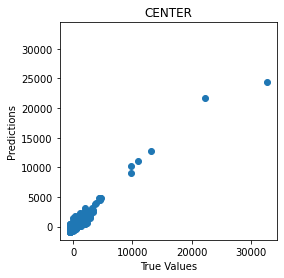

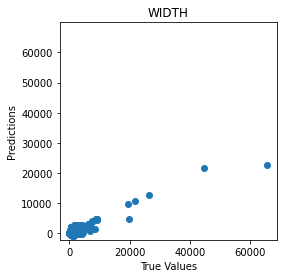

In [13]:
# Difference between true and predicted values
plot_diff(y_test[0], center_pred, title='CENTER')
plot_diff(y_test[1], width_pred, title='WIDTH')

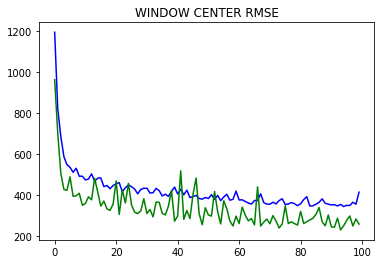

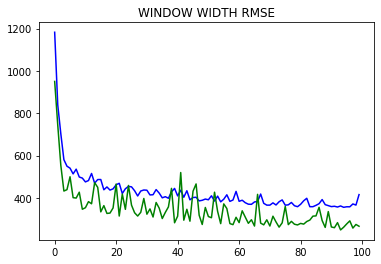

In [14]:
# Plot MSE
plot_metrics(mo_history, metric_name='window_center_root_mean_squared_error', title='WINDOW CENTER RMSE')
plot_metrics(mo_history, metric_name='window_width_root_mean_squared_error', title='WINDOW WIDTH RMSE')

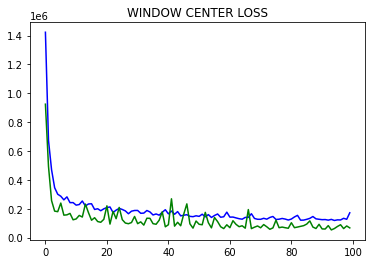

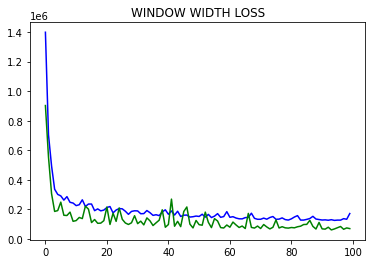

In [16]:
# Plot losses
plot_metrics(mo_history, metric_name='window_center_loss', title='WINDOW CENTER LOSS')
plot_metrics(mo_history, metric_name='window_width_loss', title='WINDOW WIDTH LOSS')

In [18]:
mo_predictions = pd.DataFrame({'Actual WindowCenter': y_test[0], 
                            'Predicted WindowCenter': center_pred.reshape(-1),
                            'WindowCenter Difference' : center_pred.reshape(-1) - y_test[0],
                            'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1] })
mo_predictions

,Actual WindowCenter,Predicted WindowCenter,WindowCenter Difference,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,40.0,-122.777199,-162.777191,300.0,158.633377,-141.366623
1,40.0,44.223167,4.223167,400.0,76.321159,-323.678833
2,45.0,132.419083,87.419083,315.0,612.759583,297.759583
3,113.0,140.725906,27.725906,227.0,148.836807,-78.163193
4,128.0,226.376022,98.376022,256.0,204.766602,-51.233398
...,...,...,...,...,...,...
2467,300.0,-233.605545,-533.605530,3000.0,-38.936531,-3038.936523
2468,2097.0,1810.715820,-286.284180,1788.0,1868.923096,80.923096
2469,-600.0,-410.817963,189.182037,1200.0,-140.146286,-1340.146240
2470,40.0,174.145737,134.145737,300.0,363.984741,63.984741


In [19]:
mo_score_center = r2_score(y_test[0], center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mo_score_center, 2) *100))
mo_score_width = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mo_score_width, 2) *100))

mo_mae_center =  mean_absolute_error(y_test[0], center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mo_mae_center, 2)))
mo_mae_width =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mo_mae_width, 2)))

mo_mse_center = mean_squared_error(y_test[0], center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mo_mse_center, 2), round(np.sqrt(mo_mse_center), 2)))
mo_mse_width = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared errory of WindowWidth is {}, RMSE: {}".format(round(mo_mse_width, 2), round(np.sqrt(mo_mse_width), 2)))

The accuracy of WindowCenter is 94.0%
The accuracy of WindowWidth is 52.0%
Mean absolute error of WindowCenter is 162.36000061035156
Mean absolute error of WindowWidth is 751.260009765625
Mean squared error of WindowCenter is 90615.2109375, RMSE: 301.0199890136719
Mean squared errory of WindowWidth is 2368393.0, RMSE: 1538.9599609375


In [21]:
#Save model
mo_model.save('./mo_model1/', save_format='tf')

INFO:tensorflow:Assets written to: ./mo_model1/assets


# TEST - ONE OUTPUT, 2 MODELS IN SEQUENCE

## CENTER ONLY MODEL

In [22]:
# custom dataset generator class
from tensorflow.keras.utils import Sequence 
class DataGeneratorArray(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


BATCH_SIZE = 32

train_data = DataGeneratorArray(x_train, np.array(y_train[0]), BATCH_SIZE)
val_data = DataGeneratorArray(x_val, np.array(y_val[0]), BATCH_SIZE)
test_data = DataGeneratorArray(x_test, np.array(y_test[0]), BATCH_SIZE)

In [24]:
def build_model_center():
    inputs = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, activation='relu') (inputs)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    #
    x = Conv2D(32, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
      
    

    x = Flatten() (x)
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    
    model = Model(inputs=inputs, outputs=[output1])
    
    return model

model_center = build_model_center()

model_center.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [25]:
model_center.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 510, 510, 8)       80        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 255, 255, 8)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 253, 253, 16)      1168      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 16)        0   

In [26]:
history_center = model_center.fit(train_data, epochs=100, validation_data=val_data, verbose=2)

Epoch 1/100
618/618 - 36s - loss: 1261195.1250 - root_mean_squared_error: 1123.0294 - val_loss: 805964.1875 - val_root_mean_squared_error: 897.7551
Epoch 2/100
618/618 - 35s - loss: 648826.3125 - root_mean_squared_error: 805.4976 - val_loss: 511018.8750 - val_root_mean_squared_error: 714.8558
Epoch 3/100
618/618 - 35s - loss: 439069.0938 - root_mean_squared_error: 662.6229 - val_loss: 231462.5312 - val_root_mean_squared_error: 481.1055
Epoch 4/100
618/618 - 35s - loss: 315435.0938 - root_mean_squared_error: 561.6360 - val_loss: 164425.0938 - val_root_mean_squared_error: 405.4936
Epoch 5/100
618/618 - 35s - loss: 296923.4688 - root_mean_squared_error: 544.9069 - val_loss: 165228.2969 - val_root_mean_squared_error: 406.4828
Epoch 6/100
618/618 - 35s - loss: 273137.0000 - root_mean_squared_error: 522.6251 - val_loss: 162281.2969 - val_root_mean_squared_error: 402.8415
Epoch 7/100
618/618 - 35s - loss: 252205.7656 - root_mean_squared_error: 502.2009 - val_loss: 368038.6875 - val_root_mean_

Epoch 57/100
618/618 - 35s - loss: 162936.0469 - root_mean_squared_error: 403.6534 - val_loss: 65688.1484 - val_root_mean_squared_error: 256.2970
Epoch 58/100
618/618 - 35s - loss: 126831.2422 - root_mean_squared_error: 356.1337 - val_loss: 84550.9062 - val_root_mean_squared_error: 290.7764
Epoch 59/100
618/618 - 35s - loss: 135655.0938 - root_mean_squared_error: 368.3138 - val_loss: 63312.9727 - val_root_mean_squared_error: 251.6207
Epoch 60/100
618/618 - 35s - loss: 134297.5938 - root_mean_squared_error: 366.4664 - val_loss: 63979.5078 - val_root_mean_squared_error: 252.9417
Epoch 61/100
618/618 - 35s - loss: 143443.7812 - root_mean_squared_error: 378.7397 - val_loss: 59961.3984 - val_root_mean_squared_error: 244.8702
Epoch 62/100
618/618 - 35s - loss: 132104.0469 - root_mean_squared_error: 363.4612 - val_loss: 55916.6328 - val_root_mean_squared_error: 236.4670
Epoch 63/100
618/618 - 35s - loss: 134892.6719 - root_mean_squared_error: 367.2774 - val_loss: 72370.5078 - val_root_mean_sq

In [18]:
#model_center = tf.keras.models.load_model('./model_centeronly1/')

In [27]:
Y_pred = model_center.predict(test_data)
center_pred = Y_pred

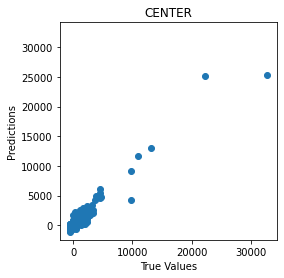

,Actual WindowCenter,Predicted WindowCenter,WindowCenter Difference
0,40.0,-122.576340,-162.576340
1,40.0,-93.334923,-133.334930
2,45.0,104.645073,59.645073
3,113.0,154.952774,41.952774
4,128.0,167.669083,39.669083
...,...,...,...
2467,300.0,-18.863302,-318.863312
2468,2097.0,1898.488159,-198.511841
2469,-600.0,-526.443420,73.556580
2470,40.0,377.653625,337.653625


In [29]:
# Plot difference
plot_diff(y_test[0], center_pred, title='CENTER')
# Plot loss
#plot_metrics(history_center,metric_name='loss', title='WINDOW CENTER LOSS')
# Plot RMSE
#plot_metrics(history_center,metric_name='root_mean_squared_error', title='WINDOW CENTER RMSE')

predictions_center = pd.DataFrame({'Actual WindowCenter': y_test[0], 
                            'Predicted WindowCenter': center_pred.reshape(-1),
                            'WindowCenter Difference' : center_pred.reshape(-1) - y_test[0]})
predictions_center

In [30]:
score_center = r2_score(y_test[0], center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(score_center, 2) *100))

mae_center =  mean_absolute_error(y_test[0], center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mae_center, 2)))

mse_center = mean_squared_error(y_test[0], center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mse_center, 2), round(np.sqrt(mse_center), 2)))

The accuracy of WindowCenter is 94.0%
Mean absolute error of WindowCenter is 150.6199951171875
Mean squared error of WindowCenter is 92591.34375, RMSE: 304.2900085449219


In [32]:
predictions_center.loc[predictions_center['WindowCenter Difference'] == predictions_center['WindowCenter Difference'].max()]

,Actual WindowCenter,Predicted WindowCenter,WindowCenter Difference
867,22317.0,25221.361328,2904.361328


In [33]:
model.save('./model_centeronly1/', save_format='tf')

## WIDTH PREDICTION MODELS

### 1. Image + WindowCenter

In [34]:
### IMAGE + WINDOWCENTER MODEL 
def build_model_imgcenter():
    input_image = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, activation='relu') (input_image)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    x = MaxPooling2D() (x)
      
    x = Flatten() (x)
    
    
    input_center = Input(shape=(1))
    y = Dense(8, activation="relu") (input_center)
    y = Dense(32, activation="relu") (y)
    y = Dense(32, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(128, activation="relu") (y)
    y= tf.keras.layers.Reshape((128,))(y)
    
    
    
    combined = tf.keras.layers.concatenate([x, y])
    output = Dense(units='1', activation='linear', name="window_width")(combined)
    model = Model(inputs=[input_image, input_center], outputs=output)
        
    #output = Dense(units='1', activation='linear', name="window_width")(y)
    #model = Model(inputs=input_center, outputs=output)
    
    return model

model_imgcenter = build_model_imgcenter()

model_imgcenter.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [35]:
model_imgcenter.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 510, 510, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 255, 255, 8)  0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 253, 253, 16) 1168        max_pooling2d_18[0][0]           
____________________________________________________________________________________________

In [36]:
history_imgcenter = model_imgcenter.fit(x=[x_train[:2000],y_train[0][:2000]], y=y_train[1][:2000], 
                      epochs=100, validation_data=([x_val[:400], y_val[0][:400]], y_val[1][:400]), verbose=2)

Epoch 1/100
63/63 - 8s - loss: 2291326.0000 - root_mean_squared_error: 1513.7126 - val_loss: 412245.8438 - val_root_mean_squared_error: 642.0637
Epoch 2/100
63/63 - 4s - loss: 551051.3750 - root_mean_squared_error: 742.3283 - val_loss: 549539.5000 - val_root_mean_squared_error: 741.3093
Epoch 3/100
63/63 - 4s - loss: 583632.5625 - root_mean_squared_error: 763.9584 - val_loss: 567363.5000 - val_root_mean_squared_error: 753.2354
Epoch 4/100
63/63 - 4s - loss: 574975.8750 - root_mean_squared_error: 758.2716 - val_loss: 410490.5625 - val_root_mean_squared_error: 640.6954
Epoch 5/100
63/63 - 4s - loss: 549394.9375 - root_mean_squared_error: 741.2118 - val_loss: 631321.4375 - val_root_mean_squared_error: 794.5574
Epoch 6/100
63/63 - 4s - loss: 599407.2500 - root_mean_squared_error: 774.2139 - val_loss: 411688.1562 - val_root_mean_squared_error: 641.6293
Epoch 7/100
63/63 - 4s - loss: 587626.8750 - root_mean_squared_error: 766.5682 - val_loss: 561141.9375 - val_root_mean_squared_error: 749.09

Epoch 58/100
63/63 - 4s - loss: 120273.0703 - root_mean_squared_error: 346.8041 - val_loss: 249989.6250 - val_root_mean_squared_error: 499.9896
Epoch 59/100
63/63 - 4s - loss: 112177.2969 - root_mean_squared_error: 334.9288 - val_loss: 284044.3125 - val_root_mean_squared_error: 532.9581
Epoch 60/100
63/63 - 4s - loss: 106301.6641 - root_mean_squared_error: 326.0394 - val_loss: 252402.7969 - val_root_mean_squared_error: 502.3970
Epoch 61/100
63/63 - 4s - loss: 98951.0234 - root_mean_squared_error: 314.5648 - val_loss: 260109.4219 - val_root_mean_squared_error: 510.0092
Epoch 62/100
63/63 - 4s - loss: 101287.2344 - root_mean_squared_error: 318.2566 - val_loss: 250299.8125 - val_root_mean_squared_error: 500.2997
Epoch 63/100
63/63 - 4s - loss: 111294.2109 - root_mean_squared_error: 333.6078 - val_loss: 263574.8125 - val_root_mean_squared_error: 513.3954
Epoch 64/100
63/63 - 4s - loss: 93799.7656 - root_mean_squared_error: 306.2675 - val_loss: 256082.7969 - val_root_mean_squared_error: 506

In [37]:
width_pred = model_imgcenter.predict([x_test[:1000], y_test[0][:1000]])

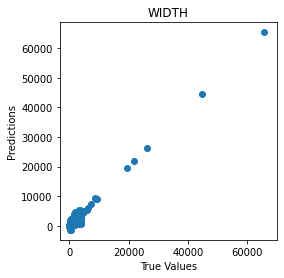

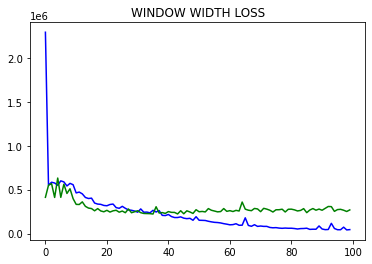

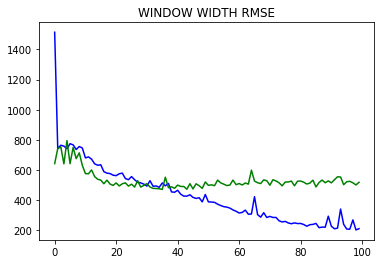

In [38]:
# Plot difference
plot_diff(y_test[1][:1000], width_pred, title='WIDTH')
# Plot loss
plot_metrics(history_imgcenter, metric_name='loss', title='WINDOW WIDTH LOSS')
# Plot RMSE
plot_metrics(history_imgcenter, metric_name='root_mean_squared_error', title='WINDOW WIDTH RMSE')

predictions_imgcenter = pd.DataFrame({'Actual WindowWidth':  y_test[1][:1000], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) -  y_test[1][:1000]})

OVERFITTING

In [39]:
predictions_imgcenter

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,300.0,988.049011,688.049011
1,400.0,265.666626,-134.333374
2,315.0,-155.606110,-470.606110
3,227.0,257.010834,30.010834
4,256.0,359.485565,103.485565
...,...,...,...
995,78.0,107.990845,29.990845
996,658.0,629.477600,-28.522400
997,909.0,1069.820557,160.820557
998,503.0,530.354919,27.354919


In [40]:
score_imgcenter = r2_score( y_test[1][:1000], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_imgcenter, 2) *100))

mae_imgcenter =  mean_absolute_error(y_test[1][:1000], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_imgcenter, 2)))

mse_imgcenter = mean_squared_error(y_test[1][:1000], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_imgcenter, 2), round(np.sqrt(mse_imgcenter), 2)))

The accuracy of WindowWidth is 97.0%
Mean absolute error of WindowWidth is 320.5
Mean squared error of WindowWidth is 317870.96875, RMSE: 563.7999877929688


In [43]:
predictions_imgcenter['WindowWidth Difference'].min()

-3434.6182

In [44]:
predictions_imgcenter.loc[predictions_imgcenter['WindowWidth Difference'] == -7064.383]

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
481,65535.0,58470.617188,-7064.382812


In [46]:
#model_imgcenter.save('./model_width_imgcenter1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_width_imgcenter1/assets


### 2. Image Only

In [44]:
BATCH_SIZE = 32

train_data = DataGeneratorArray(x_train, np.array(y_train[1]), BATCH_SIZE)
val_data = DataGeneratorArray(x_val, np.array(y_val[1]), BATCH_SIZE)
test_data = DataGeneratorArray(x_test, np.array(y_test[1]), BATCH_SIZE)

In [45]:
def build_model_imgonly():
    inputs = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, activation='relu') (inputs)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    #
    x = Conv2D(32, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    #x = BatchNormalization() (x)
    x = MaxPooling2D() (x)
      
    

    x = Flatten() (x)
    output1 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=inputs, outputs=[output1])
    
    return model

model_imgonly = build_model_imgonly()

model_imgonly.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [46]:
model_imgonly.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 510, 510, 8)       80        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 255, 255, 8)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 253, 253, 16)      1168      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 62, 62, 16)        0   

In [47]:
history_imgonly = model_imgonly.fit(train_data, epochs=100, validation_data=val_data, verbose=2)

Epoch 1/100
618/618 - 36s - loss: 5610033.5000 - root_mean_squared_error: 2368.5510 - val_loss: 3011629.5000 - val_root_mean_squared_error: 1735.4047
Epoch 2/100
618/618 - 34s - loss: 2803715.5000 - root_mean_squared_error: 1674.4299 - val_loss: 2337004.0000 - val_root_mean_squared_error: 1528.7262
Epoch 3/100
618/618 - 34s - loss: 2478681.0000 - root_mean_squared_error: 1574.3827 - val_loss: 2379071.2500 - val_root_mean_squared_error: 1542.4238
Epoch 4/100
618/618 - 35s - loss: 2043673.0000 - root_mean_squared_error: 1429.5709 - val_loss: 1932475.8750 - val_root_mean_squared_error: 1390.1351
Epoch 5/100
618/618 - 34s - loss: 1661949.2500 - root_mean_squared_error: 1289.1661 - val_loss: 1034883.4375 - val_root_mean_squared_error: 1017.2922
Epoch 6/100
618/618 - 35s - loss: 1285530.7500 - root_mean_squared_error: 1133.8125 - val_loss: 679991.0000 - val_root_mean_squared_error: 824.6157
Epoch 7/100
618/618 - 34s - loss: 1155424.1250 - root_mean_squared_error: 1074.9066 - val_loss: 602919

Epoch 57/100
618/618 - 33s - loss: 703221.7500 - root_mean_squared_error: 838.5832 - val_loss: 500158.5938 - val_root_mean_squared_error: 707.2189
Epoch 58/100
618/618 - 33s - loss: 644315.2500 - root_mean_squared_error: 802.6925 - val_loss: 415889.7500 - val_root_mean_squared_error: 644.8951
Epoch 59/100
618/618 - 33s - loss: 688915.7500 - root_mean_squared_error: 830.0095 - val_loss: 398408.1875 - val_root_mean_squared_error: 631.1958
Epoch 60/100
618/618 - 33s - loss: 643772.4375 - root_mean_squared_error: 802.3543 - val_loss: 374856.0625 - val_root_mean_squared_error: 612.2549
Epoch 61/100
618/618 - 33s - loss: 652843.2500 - root_mean_squared_error: 807.9872 - val_loss: 369330.4688 - val_root_mean_squared_error: 607.7256
Epoch 62/100
618/618 - 33s - loss: 639431.2500 - root_mean_squared_error: 799.6444 - val_loss: 399695.1562 - val_root_mean_squared_error: 632.2145
Epoch 63/100
618/618 - 33s - loss: 651783.8750 - root_mean_squared_error: 807.3314 - val_loss: 763737.8125 - val_root_

In [48]:
width_pred = model_imgonly.predict(test_data) 

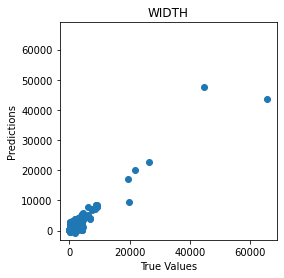

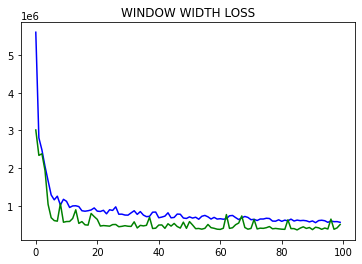

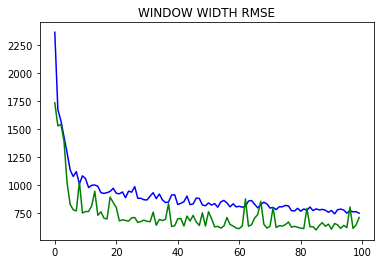

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,300.0,747.530640,447.530640
1,400.0,487.532715,87.532715
2,315.0,824.373108,509.373108
3,227.0,306.491394,79.491394
4,256.0,260.657776,4.657776
...,...,...,...
2467,3000.0,395.036804,-2604.963135
2468,1788.0,1734.267944,-53.732056
2469,1200.0,1297.238159,97.238159
2470,300.0,1104.263428,804.263428


In [49]:
# Plot difference
plot_diff(y_test[1], width_pred, title='WIDTH')
# Plot loss
plot_metrics(history_imgonly, metric_name='loss', title='WINDOW WIDTH LOSS')
# Plot RMSE
plot_metrics(history_imgonly, metric_name='root_mean_squared_error', title='WINDOW WIDTH RMSE')

predictions_imgonly = pd.DataFrame({'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1]})
predictions_imgonly

In [50]:
score_imgonly = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_imgonly, 2) *100))

mae_imgonly =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_imgonly, 2)))

mse_imgonly = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_imgonly, 2), round(np.sqrt(mse_imgonly), 2)))

The accuracy of WindowWidth is 88.0%
Mean absolute error of WindowWidth is 361.95001220703125
Mean squared error of WindowWidth is 591148.25, RMSE: 768.8599853515625


In [51]:
predictions_imgonly.loc[predictions_imgonly['WindowWidth Difference'] == predictions_imgonly['WindowWidth Difference'].min()]

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
33,65535.0,43584.902344,-21950.097656


In [52]:
model_imgonly.save('./model_width_imgonly1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_width_imgonly1/assets


### 3. WindowCenter Only

In [54]:
def build_model_centeronly():    
    input_center = Input(shape=(1))
    y = Dense(8, activation="relu") (input_center)
    y = Dense(32, activation="relu") (y)
    y = Dense(32, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(128, activation="relu") (y)
    output = Dense(units='1', activation='linear', name="window_width")(y)
    model = Model(inputs=input_center, outputs=output)
    
    return model

model_centeronly = build_model_centeronly()

model_centeronly.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [55]:
model_centeronly.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_13 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320

In [56]:
history_centeronly = model_centeronly.fit(y_train[0],y_train[1], epochs=100, validation_data=(y_val[0], y_val[1]), verbose=2)

Epoch 1/100
618/618 - 5s - loss: 834228.4375 - root_mean_squared_error: 913.3611 - val_loss: 595710.6250 - val_root_mean_squared_error: 771.8229
Epoch 2/100
618/618 - 5s - loss: 631998.0000 - root_mean_squared_error: 794.9830 - val_loss: 682057.1875 - val_root_mean_squared_error: 825.8675
Epoch 3/100
618/618 - 5s - loss: 629133.2500 - root_mean_squared_error: 793.1792 - val_loss: 583203.8125 - val_root_mean_squared_error: 763.6778
Epoch 4/100
618/618 - 5s - loss: 655719.6250 - root_mean_squared_error: 809.7651 - val_loss: 608918.8750 - val_root_mean_squared_error: 780.3325
Epoch 5/100
618/618 - 5s - loss: 592857.8125 - root_mean_squared_error: 769.9726 - val_loss: 580710.2500 - val_root_mean_squared_error: 762.0435
Epoch 6/100
618/618 - 5s - loss: 633038.1875 - root_mean_squared_error: 795.6370 - val_loss: 572055.6250 - val_root_mean_squared_error: 756.3436
Epoch 7/100
618/618 - 5s - loss: 647835.9375 - root_mean_squared_error: 804.8826 - val_loss: 783411.3750 - val_root_mean_squared_e

Epoch 58/100
618/618 - 5s - loss: 383131.4062 - root_mean_squared_error: 618.9761 - val_loss: 413684.5312 - val_root_mean_squared_error: 643.1831
Epoch 59/100
618/618 - 5s - loss: 399556.0938 - root_mean_squared_error: 632.1045 - val_loss: 411123.7188 - val_root_mean_squared_error: 641.1893
Epoch 60/100
618/618 - 5s - loss: 374809.2812 - root_mean_squared_error: 612.2167 - val_loss: 391687.4688 - val_root_mean_squared_error: 625.8494
Epoch 61/100
618/618 - 5s - loss: 374708.1562 - root_mean_squared_error: 612.1341 - val_loss: 392812.5625 - val_root_mean_squared_error: 626.7476
Epoch 62/100
618/618 - 5s - loss: 395055.8125 - root_mean_squared_error: 628.5347 - val_loss: 413616.6875 - val_root_mean_squared_error: 643.1304
Epoch 63/100
618/618 - 5s - loss: 376360.3438 - root_mean_squared_error: 613.4822 - val_loss: 389192.1562 - val_root_mean_squared_error: 623.8527
Epoch 64/100
618/618 - 5s - loss: 372908.1875 - root_mean_squared_error: 610.6620 - val_loss: 392450.7812 - val_root_mean_sq

In [57]:
width_pred = model_centeronly.predict(y_test[0]) 

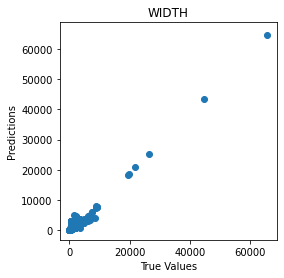

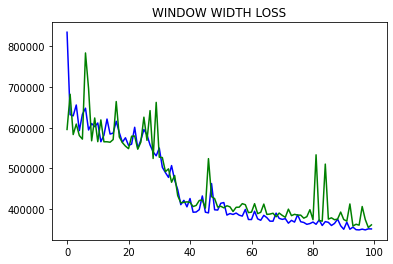

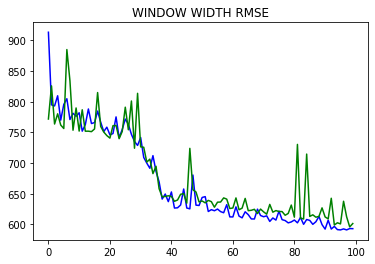

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,300.0,362.402252,62.402252
1,400.0,362.402252,-37.597748
2,315.0,280.477081,-34.522919
3,227.0,269.037170,42.037170
4,256.0,318.608612,62.608612
...,...,...,...
2467,3000.0,1267.545288,-1732.454712
2468,1788.0,3301.538086,1513.538086
2469,1200.0,1248.216431,48.216431
2470,300.0,362.402161,62.402161


In [58]:
# Plot difference
plot_diff(y_test[1], width_pred, title='WIDTH')
# Plot loss
plot_metrics(history_centeronly, metric_name='loss', title='WINDOW WIDTH LOSS')
# Plot RMSE
plot_metrics(history_centeronly, metric_name='root_mean_squared_error', title='WINDOW WIDTH RMSE')

predictions_centeronly = pd.DataFrame({'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1]})
predictions_centeronly

In [59]:
score_centeronly = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_centeronly, 2) *100))

mae_centeronly =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_centeronly, 2)))

mse_centeronly = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_centeronly, 2), round(np.sqrt(mse_centeronly), 2)))

The accuracy of WindowWidth is 93.0%
Mean absolute error of WindowWidth is 364.0400085449219
Mean squared error of WindowWidth is 329076.625, RMSE: 573.6500244140625


In [60]:
model_centeronly.save('./model_width_centeronly1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_width_centeronly1/assets


## idea - Check "compouded error" for having a model predict WindowCenter and use those predictions to feed the next model in line

In [61]:
width_pred = model_centeronly.predict(center_pred) 

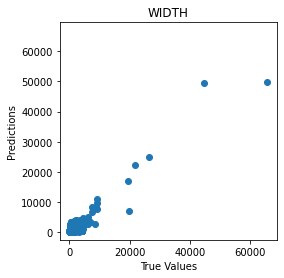

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,300.0,595.633850,295.633850
1,400.0,967.639954,567.639954
2,315.0,293.649323,-21.350677
3,227.0,438.956573,211.956573
4,256.0,445.870392,189.870392
...,...,...,...
2467,3000.0,1808.220825,-1191.779175
2468,1788.0,2961.013672,1173.013672
2469,1200.0,1032.508911,-167.491089
2470,300.0,555.873108,255.873108


In [62]:
# Plot difference
plot_diff(y_test[1], width_pred, title='WIDTH')
predictions_compound = pd.DataFrame({'Actual WindowWidth': y_test[1], 
                            'Predicted WindowWidth': width_pred.reshape(-1),
                            'WindowWidth Difference' : width_pred.reshape(-1) - y_test[1]})
predictions_compound

In [63]:
score_centeronly = r2_score(y_test[1], width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(score_centeronly, 2) *100))

mae_centeronly =  mean_absolute_error(y_test[1], width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mae_centeronly, 2)))

mse_centeronly = mean_squared_error(y_test[1], width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mse_centeronly, 2), round(np.sqrt(mse_centeronly), 2)))

The accuracy of WindowWidth is 85.0%
Mean absolute error of WindowWidth is 518.4299926757812
Mean squared error of WindowWidth is 759378.75, RMSE: 871.4199829101562


# IMPACT OF MODALITY, BODY PART EXAMINED AND HIGHBIT ON RESULTS

In [64]:
# 0. read metadata
df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
df = df.drop(columns=['WindowCenter' ,'WindowWidth', 'Rows', 'Columns', 'StudyDescription'])
df = df.fillna(value='UNKNOWN')
mod_dummies = pd.get_dummies(df.Modality)
bpe_dummies = pd.get_dummies(df.BodyPartExamined)
df = pd.concat([df,mod_dummies, bpe_dummies], axis='columns')
df = df.drop(columns=['Modality' ,'BodyPartExamined', 'XA','UNKNOWN'])

In [65]:
df

,HighBit,CR,CT,MR,NM,RF,ABDOM,ABDOMEN,ANKLE,BREAST,...,L_SPNE,NECK,PELVIS,SHOULDER,SKULL,SPINE,TEST,THORAX,TSPINE,UP_EXM
id,,,,,,,,,,,,,,,,,,,,,
2460558,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2854204,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2905685,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928440,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928448,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30762622,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30777208,11,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30782601,11,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TO DO - create train test splits with different set of labels, then distribute them into different arrays. Make a multiple input model with images and helper labels. Use the best configuration of the above models. 

In [66]:
df = pd.concat([metadata_df, df], axis='columns')

In [67]:
df

,WindowCenter,WindowWidth,HighBit,CR,CT,MR,NM,RF,ABDOM,ABDOMEN,...,L_SPNE,NECK,PELVIS,SHOULDER,SKULL,SPINE,TEST,THORAX,TSPINE,UP_EXM
id,,,,,,,,,,,,,,,,,,,,,
2460558,1905.0,2300.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2854204,2048.0,4096.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2905685,115.0,109.0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928440,2048.0,4096.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2928448,2048.0,4096.0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30762622,1256.0,2527.0,11,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30777208,-600.0,1200.0,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30782601,35.0,80.0,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
np.array(df).shape

(24719, 35)

In [73]:
# custom dataset generator class
from tensorflow.keras.utils import Sequence 
class DataGeneratorArray(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

    
# format datasets - return tuple
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width


# 1. create train-validation-test dataset splits
# choose train, validation and test rations
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train - test split
x_train_img, x_test_img, x_train_meta, x_test_meta = train_test_split(images, df, test_size=1-train_ratio)

# test - validation split,validation is treated as train data
x_val_img, x_test_img, x_val_meta, x_test_meta = train_test_split(x_test_img, x_test_meta, test_size=test_ratio/(test_ratio + validation_ratio))

In [74]:
y_train = format_output(x_train_meta)
y_val = format_output(x_val_meta)
y_test = format_output(x_test_meta)

In [75]:
x_train_meta = np.array(x_train_meta)
x_val_meta = np.array(x_val_meta)
x_test_meta = np.array(x_test_meta)

In [76]:
del images

## WindowCenter Predictions With Help of Metadata

In [70]:
### IMAGE + METADATA MODEL 
def build_model_imgmeta():
    input_image = Input(shape=(512, 512, 1))
    x = Conv2D(8, 3, activation='relu') (input_image)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(16, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(16, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(32, 3, activation='relu') (x)
    x = MaxPooling2D() (x)  
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(64, 3, 1, activation='relu') (x)
    x = MaxPooling2D() (x)
      
    x = Flatten() (x)
    
    
    input_meta = Input(shape=(33))
    y = Dense(8, activation="relu") (input_meta)
    y = Dense(32, activation="relu") (y)
    y = Dense(32, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(64, activation="relu") (y)
    y = Dense(128, activation="relu") (y)
    y= tf.keras.layers.Reshape((128,))(y)
    
    
    
    combined = tf.keras.layers.concatenate([x, y])
    output = Dense(units='1', activation='linear', name="window_center")(combined)
    model = Model(inputs=[input_image, input_meta], outputs=output)
    
    return model

model_imgmeta = build_model_imgmeta()

model_imgmeta.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.MeanSquaredError(), 
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [71]:
model_imgmeta.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 510, 510, 8)  80          input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 255, 255, 8)  0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 253, 253, 16) 1168        max_pooling2d_32[0][0]           
____________________________________________________________________________________________

In [77]:
history_imgmeta = model_imgmeta.fit(x=[x_train_img[:2000],x_train_meta[:2000]], y=y_train[0][:2000], 
                      epochs=100, validation_data=([x_val_img[:400], x_val_meta[:400]], y_val[0][:400]), verbose=2)

Epoch 1/100
63/63 - 15s - loss: 1882192.6250 - root_mean_squared_error: 1371.9303 - val_loss: 2029723.8750 - val_root_mean_squared_error: 1424.6838
Epoch 2/100
63/63 - 4s - loss: 1426533.3750 - root_mean_squared_error: 1194.3757 - val_loss: 1947261.2500 - val_root_mean_squared_error: 1395.4430
Epoch 3/100
63/63 - 4s - loss: 1383115.1250 - root_mean_squared_error: 1176.0591 - val_loss: 1885166.1250 - val_root_mean_squared_error: 1373.0134
Epoch 4/100
63/63 - 4s - loss: 1349857.5000 - root_mean_squared_error: 1161.8336 - val_loss: 1908017.8750 - val_root_mean_squared_error: 1381.3102
Epoch 5/100
63/63 - 4s - loss: 1296831.7500 - root_mean_squared_error: 1138.7852 - val_loss: 1729336.5000 - val_root_mean_squared_error: 1315.0424
Epoch 6/100
63/63 - 4s - loss: 1234137.1250 - root_mean_squared_error: 1110.9172 - val_loss: 1689389.5000 - val_root_mean_squared_error: 1299.7651
Epoch 7/100
63/63 - 4s - loss: 1175637.3750 - root_mean_squared_error: 1084.2681 - val_loss: 1388097.5000 - val_root_

Epoch 58/100
63/63 - 4s - loss: 374295.2188 - root_mean_squared_error: 611.7967 - val_loss: 355585.6875 - val_root_mean_squared_error: 596.3101
Epoch 59/100
63/63 - 4s - loss: 366359.2500 - root_mean_squared_error: 605.2762 - val_loss: 349730.9062 - val_root_mean_squared_error: 591.3805
Epoch 60/100
63/63 - 4s - loss: 363956.8438 - root_mean_squared_error: 603.2883 - val_loss: 343227.4062 - val_root_mean_squared_error: 585.8561
Epoch 61/100
63/63 - 4s - loss: 365087.2500 - root_mean_squared_error: 604.2245 - val_loss: 411084.5312 - val_root_mean_squared_error: 641.1588
Epoch 62/100
63/63 - 4s - loss: 421290.7812 - root_mean_squared_error: 649.0692 - val_loss: 389145.1875 - val_root_mean_squared_error: 623.8150
Epoch 63/100
63/63 - 4s - loss: 447734.2500 - root_mean_squared_error: 669.1295 - val_loss: 928561.8125 - val_root_mean_squared_error: 963.6191
Epoch 64/100
63/63 - 4s - loss: 583673.8125 - root_mean_squared_error: 763.9855 - val_loss: 519542.8438 - val_root_mean_squared_error: 7

In [78]:
center_pred = model_imgmeta.predict([x_test_img[:1000], x_test_meta[:1000]])

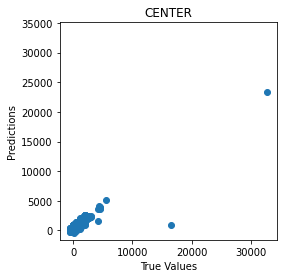

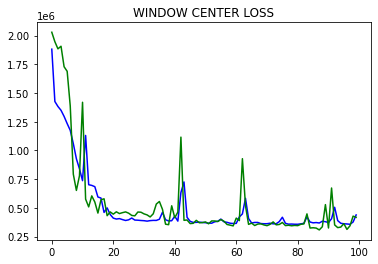

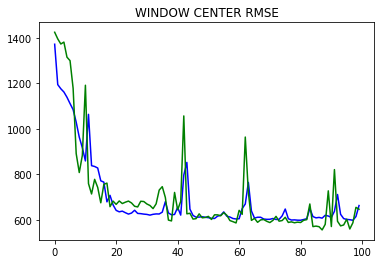

,Actual WindowWidth,Predicted WindowWidth,WindowWidth Difference
0,60.0,171.383377,111.383377
1,216.0,320.866180,104.866180
2,1776.0,2022.397583,246.397583
3,360.0,419.892212,59.892212
4,280.0,548.782471,268.782471
...,...,...,...
995,157.0,187.681503,30.681503
996,2047.0,2125.639404,78.639404
997,40.0,-59.887520,-99.887520
998,551.0,873.868713,322.868713


In [79]:
# Plot difference
plot_diff(y_test[0][:1000], center_pred, title='CENTER')
# Plot loss
plot_metrics(history_imgmeta, metric_name='loss', title='WINDOW CENTER LOSS')
# Plot RMSE
plot_metrics(history_imgmeta, metric_name='root_mean_squared_error', title='WINDOW CENTER RMSE')

predictions_imgmeta = pd.DataFrame({'Actual WindowWidth': y_test[0][:1000], 
                            'Predicted WindowWidth': center_pred.reshape(-1),
                            'WindowWidth Difference' : center_pred.reshape(-1) - y_test[0][:1000]})
predictions_imgmeta

In [81]:
score_imgmeta = r2_score(y_test[0][:1000], center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(score_imgmeta, 2) *100))

mae_imgmeta =  mean_absolute_error(y_test[0][:1000], center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mae_imgmeta, 2)))

mse_imgmeta = mean_squared_error(y_test[0][:1000], center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mse_imgmeta, 2), round(np.sqrt(mse_imgmeta), 2)))

The accuracy of WindowCenter is 79.0%
Mean absolute error of WindowCenter is 247.8800048828125
Mean squared error of WindowCenter is 423582.28125, RMSE: 650.8300170898438


In [69]:
model_imgmeta.save('./model_center_imgmeta1/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_center_imgmeta1/assets
